### Проект e-commerce


Поставленные перед нами вопросы
1. Сколько у нас пользователей, которые совершили покупку только один раз?   

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?  

3. По каждому товару определить, в какой день недели товар чаще всего покупается.  

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.   

5.1. Выполните когортный анализ пользователей.  

5.2. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц. Описание подхода можно найти тут. Для визуализации когортной таблицы рекомендуем использовать пример из этого конспекта.  

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

#### Описание файлов и их содержания:

##### olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей
customer_id — позаказный идентификатор пользователя

customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

customer_zip_code_prefix —  почтовый индекс пользователя

customer_city —  город доставки пользователя

customer_state —  штат доставки пользователя

##### olist_orders_dataset.csv —  таблица заказов
order_id —  уникальный идентификатор заказа (номер чека)

customer_id —  позаказный идентификатор пользователя

order_status —  статус заказа

order_purchase_timestamp —  время создания заказа

order_approved_at —  время подтверждения оплаты заказа

order_delivered_carrier_date —  время передачи заказа в логистическую службу

order_delivered_customer_date —  время доставки заказа

order_estimated_delivery_date —  обещанная дата доставки

##### olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
order_id —  уникальный идентификатор заказа (номер чека)

order_item_id —  идентификатор товара внутри одного заказа

product_id —  ид товара (аналог штрихкода)

seller_id — ид производителя товара

shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

price —  цена за единицу товара

freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

created —  создан  
approved —  подтверждён  
invoiced —  выставлен счёт  
processing —  в процессе сборки заказа  
shipped —  отгружен со склада  
delivered —  доставлен пользователю  
unavailable —  недоступен  
canceled —  отменён  

In [1]:
# импортируем данные
import pandas as pd
# таблица с уникальными идентификаторами пользователей
customers = pd.read_csv('olist_customers_dataset.csv')
# таблица заказов
order_items = pd.read_csv('olist_order_items_dataset.csv')
# товарные позиции, входящие в заказы
orders= pd.read_csv('olist_orders_dataset.csv')

Посмотрим на информацию таблицы пользователей

In [2]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [3]:
customers.shape

(99441, 5)

In [4]:
# посмотрим сколько у нас уникальных пользователей
customers.customer_unique_id.nunique()

96096

In [5]:
# посмотрим сколько у нас уникальных заказов
customers.customer_id.nunique()

99441

In [6]:
# проверим на пропущенные значения
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Посмотрим на информацию таблицы товарных позиций, входящих в заказы

In [7]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [8]:
orders.shape

(99441, 8)

In [9]:
# проверим на пропущенные значения
orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Видим, что не везде есть даты. Можно объяснить тем, что не все заказы успешно завершены

In [10]:
# всего заказов
orders.order_id.nunique()

99441

In [11]:
# Посмотрим как заказы разбиваются по статусам
orders.groupby("order_status", as_index = False).agg({"customer_id": "count"})

,order_status,customer_id
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


Посмотрим на информацию таблицы заказов

In [12]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [13]:
order_items.order_id.nunique()

98666

Получилось число меньшее общего числа пользователей на 775 человек

In [14]:
order_items.shape

(112650, 7)

In [15]:
# проверим на пропущенные значения
order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [16]:
# объединим таблицы покупателей и  товарных позиций, входящих в заказы
customers_orders = customers.merge(orders)

### 1. Сколько у нас пользователей, которые совершили покупку только один раз?


Для начала нужно посмотреть на статусы заказов.  
- approved: заказ подтвержден, т.е. его увидели на сайте, но это не говорит о том, что он успешно завершён.

- canceled: заказ отменен (может быть по инициативе клиента или продавца)

- created: заказ создан, можно сказать, что пользователь только добавил товар в свою корзину.

- delivered: заказ доставлен.

- invoiced: выставлен счет, но заказ не был обработан дальше. Если не пройдет дальнейшая оплата покупка не будет совершена.

- processing: заказ находится в процессе сборки, закзаз уже оплачен, но еще не был доставлен.

- shipped: заказ отправлен, но еще не доставлен.  

- unavailable: товар недоступен (например, нет на складе).

Заказы со статусами processing, shipped, delivered можно считать оплаченными, а значит пользователь совершил покупку.

In [17]:
# посчитаем сколько пользователей совершили только 1 покупку
buy_1 = customers_orders.query("order_status == ['processing', 'shipped', 'delivered']") \
                .groupby("customer_unique_id", as_index=False) \
                .agg({"customer_zip_code_prefix": "count"}) \
                .query("customer_zip_code_prefix == 1").shape[0]
buy_1

91814

### 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [18]:
# посчитаем заказы по статусу "недоставлен"
orders.query("order_status != 'delivered'").shape[0]

2963

In [19]:
# посчитаем заказы, у которых нет статуса доставки
orders.order_delivered_customer_date.isna().sum()

2965

При этих подходах получились почти равные значения. 

Посмотрим на недоставленные заказы, у которых нет даты доставки. Выясним какие там есть статусы.

In [20]:
orders[orders.order_delivered_customer_date.isna()].head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaN,NaN,2017-05-09 00:00:00
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaN,2018-06-28 00:00:00
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaN,NaN,2018-08-21 00:00:00
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaN,NaN,2017-10-03 00:00:00
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaN,2018-02-07 00:00:00


In [21]:
orders[orders.order_delivered_customer_date.isna()].order_status.unique()

array(['invoiced', 'shipped', 'processing', 'unavailable', 'canceled',
       'delivered', 'created', 'approved'], dtype=object)

Тут видим все статусы заказов. Часть заказов еще не доставлены по объективным причинам: не подтверждены, не выставлен счет, не отгружены со склада, еще не довезли. Также стоит отметить, что некоторые заказы были отменены или закончились на складе. Но есть и те, у которых стоит статус "delivered", возможно это сбой. Не стоит учитывать эти заказы.

In [22]:
# исключим эти заказы
orders.query("order_status != 'delivered'")[orders.query("order_status != 'delivered'").order_delivered_customer_date.isna()].shape[0]

2957

Теперь мы видим, что у нас 2957 заказов, недоставленных по разным причинам. Из которых исключили те, у которых нет даты доставки и статус "delivered".

Можно посчитать другим способом. Взять все статусы, кроме "delivered" и уже потом удалить те, у которых нет даты доставки.

In [23]:
orders.query("order_status != 'delivered'")[orders.query("order_status != 'delivered'").order_delivered_customer_date.isna()].shape[0]

2957

Теперь посмотрим сколько не доставляется в среднем по месяцам.  Для начала создадим новый датафрейм с недоставленными заказами.

In [24]:
no_delivered = orders[orders.order_delivered_customer_date.isna()].query("order_status != 'delivered'")

In [25]:
no_delivered['order_purchase_timestamp'] = pd.to_datetime(no_delivered['order_purchase_timestamp'])

In [26]:
no_delivered.order_purchase_timestamp = no_delivered.order_purchase_timestamp.dt.strftime('%Y-%m')

In [27]:
#посчитаем кол-во недоставленных заказов по каждой причине за каждый месяц, далее среднее значение для каждой причины
no_delivered.groupby(["order_purchase_timestamp", "order_status"], as_index=False) \
    .agg({"customer_id": "count"}) \
    .groupby("order_status") \
    .agg({"customer_id": "mean"}) \
    .round() \
    .sort_values("customer_id")

,customer_id
order_status,
approved,1.0
created,2.0
invoiced,15.0
processing,16.0
canceled,26.0
unavailable,29.0
shipped,48.0


### 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [28]:
# объеденим таблицы с заказами и данными п заказам
order_union = orders.merge(order_items)

In [29]:
order_union.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


В предущем вопросе мы определили статусы, которые считаются покупкой: "processing", "shipped", '"delivered". Выберем только эти статусы.

In [30]:
order_union = order_union.query("order_status == ['processing', 'shipped', 'delivered']")

У нас есть только одна колонка с датами, оттуда и возьмем день недели.

In [31]:
order_union['order_purchase_timestamp'] = pd.to_datetime(order_union['order_purchase_timestamp'])

In [32]:
order_union['order_purchase_timestamp'] = order_union['order_purchase_timestamp'].dt.day_name()

In [33]:
order_union.groupby(["product_id", "order_purchase_timestamp"], as_index=False) \
    .agg({"customer_id": "count"}) \
    .sort_values(by="customer_id", ascending=False) \
    .drop_duplicates(subset='product_id')

,product_id,order_purchase_timestamp,customer_id
15766,422879e10f46682990de24d770e7f83d,Wednesday,93
36178,99a4788cb24856965c36a24e339b6058,Monday,92
40679,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
19944,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
13422,389d119b48cf3043d311335e499d9c6b,Thursday,67
...,...,...,...
23811,6435be64ad92f52631170f9a92718a99,Sunday,1
23813,64367bed3ed96fd9381676fbe33b6443,Sunday,1
23814,643a4049ae3e6df63858575f28cd7b21,Friday,1
23816,643a66b1dc5dad3de6cb5a41549e72f1,Sunday,1


### 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Для начала добавим к нашему объединенному датафрейму последнюю таблицу. Потом снова приведем даты к месяцам.

In [34]:
df = customers_orders.merge(order_items)

In [35]:
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [36]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], format='%Y-%m-%d', errors='coerce')

In [37]:
#приведём даты обратно к месяцам, потому что нас интересуют данные по месяцам месяца
df['order_purchase_timestamp'] = df['order_purchase_timestamp'].dt.strftime('%Y-%m')

Теперь можем посчитать количество покупок каждого пользователя за каждый месяц.

In [38]:
df_mon_bye = df.groupby(["customer_id", "order_purchase_timestamp"], as_index=False) \
    .agg({"customer_state":"count"})

In [39]:
# сделаем дополнительный столбец с месяцем
df_mon_bye["Mon"] = df_mon_bye.order_purchase_timestamp

In [40]:
# сделать из назманием месяца его номер
df_mon_bye["Mon"] = pd.to_datetime(df_mon_bye["Mon"]).dt.month

In [41]:
# Теперь нужна функциюя, которая посчитает сколько дней в каждом месяце
def week(mon):
        if mon == 2:
            x = 28
        elif mon == 4:
            x = 30
        elif mon == 6:
            x = 30
        elif mon == 9:
            x = 30
        elif mon == 11:
            x = 30
        else:
            x = 31
        return x 

In [42]:
# теперь применим эту функцию
df_mon_bye.Mon = df_mon_bye.Mon.apply(week)

In [43]:
df_mon_bye.Mon.head()

0    30
1    31
2    28
3    31
4    30
Name: Mon, dtype: int64

In [44]:
df_mon_bye["metrika"] = (df_mon_bye.customer_state / df_mon_bye.Mon)

In [45]:
df_mon_bye.head(10)

,customer_id,order_purchase_timestamp,customer_state,Mon,metrika
0,00012a2ce6f8dcda20d059ce98491703,2017-11,1,30,0.033333
1,000161a058600d5901f007fab4c27140,2017-07,1,31,0.032258
2,0001fd6190edaaf884bcaf3d49edf079,2017-02,1,28,0.035714
3,0002414f95344307404f0ace7a26f1d5,2017-08,1,31,0.032258
4,000379cdec625522490c315e70c7a9fb,2018-04,1,30,0.033333
5,0004164d20a9e969af783496f3408652,2017-04,1,30,0.033333
6,000419c5494106c306a97b5635748086,2018-03,1,31,0.032258
7,00046a560d407e99b969756e0b10f282,2017-12,1,31,0.032258
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09,1,30,0.033333
9,000598caf2ef4117407665ac33275130,2018-08,1,31,0.032258


### 5. Выполните когортный анализ пользователей. В период с января по декабрь выявите когорту с самым высоким retention на 3-й месяц.

Чтобы рассчитать Retention, нужно знать динамику количества активных пользователей определенной когорты по днам (неделям, месяцам)  
- взять число новых пользователей в день 0 (день, когда группа пользователей пришла)
- взять число активных пользователей в день N (интересующий нас день для рассчета метрики Retention) 
- разделить второе значние на первое, и результат умножить на 100
- Day N Retention = (Users Day N / Users Day 0) * 100 
- Пример: Day 7 Retention = (505/1300)*100 = 38%

In [46]:
cust_orders = customers_orders

In [47]:
cust_orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


Найдем когорту.

In [48]:
cust_orders['order_purchase_timestamp'] = pd.to_datetime(cust_orders['order_purchase_timestamp'])
cust_orders['cohort'] = cust_orders['order_purchase_timestamp'].dt.to_period('M')

Выясним, когда у нас была первая покупка у каждого пользователя

In [49]:
cust_orders['first_buy'] = cust_orders.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')


Теперь посчитаем когортный период. Представляет собой разницу между текущим месяцем и месяцем первой покупки.

In [50]:
cust_orders['cohort_period'] = (cust_orders['cohort'] - cust_orders['first_buy']).apply (lambda x:x.n)

Теперь, чтобы найти количество пользователей сгруппируем по месяцам первой покупки и когортным периодам.

In [51]:
cohort_data = cust_orders.groupby(['first_buy', 'cohort_period'])['customer_unique_id']\
                         .nunique().reset_index()

Сделаем когортныую таблицу.

In [52]:
cohort_table = cohort_data.pivot_table(index='first_buy', columns='cohort_period', values='customer_unique_id')

Сделаемнормализацию данных на основании размера когорты

In [53]:
cohort_size = cohort_table.iloc[:,0]

In [54]:
retention_matrix = cohort_table.divide(cohort_size, axis = 0)

Сделаем фильтрацию когорты, согласно нашим условиям. С января по декабрь.

In [55]:
filt_retention = retention_matrix[(retention_matrix.index >= '2017-01') & (retention_matrix.index <= '2017-12')]

Найдем когорту с самым большим retention на 3 месяц

In [56]:
max_retention_cohort = filt_retention[3].idxmax()
max_retention_value = filt_retention[3].max()

In [57]:
print(f'Когорта с самым большим retention на 3 месяц : {max_retention_cohort}')
print(f'Retention на 3 месяц : {max_retention_value:.2%}')

Когорта с самым большим retention на 3 месяц : 2017-06
Retention на 3 месяц : 0.41%


Сделаем визуализацию

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

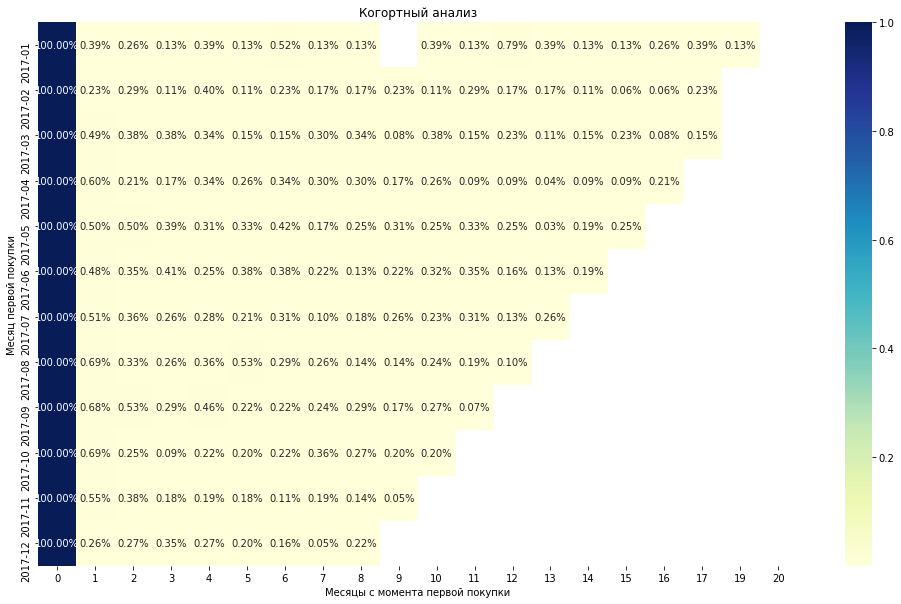

In [59]:
plt.figure(figsize=(17, 10))
sns.heatmap(filt_retention, annot=True, fmt='.2%', cmap="YlGnBu")
plt.title('Когортный анализ', fontsize=12)
plt.ylabel('Месяц первой покупки')
plt.xlabel('Месяцы с момента первой покупки')
plt.show()

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 
В кластеризации можешь выбрать следующие метрики:  
- R - время от последней покупки пользователя до текущей даты, 
- F - суммарное количество покупок у пользователя за всё время, 
- M - сумма покупок за всё время.  

Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. 

В этом задании для работы нам нужно взять таблицы с заказами и товарными позициями.

In [60]:
df6 = df.dropna().query('order_status == ["processing", "shipped", "delivered"]')


In [61]:
df6.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


Посчитаем дату последнего заказа.

In [62]:
df6['order_approved_at'] = pd.to_datetime(df6['order_approved_at'])

In [63]:
last_order_date = df6['order_approved_at'].max() + pd.Timedelta(days=1)

Сделаем рассчет RFM-метрик

In [64]:
rfm = df6.groupby('customer_unique_id', as_index=False) \
    .agg({'order_approved_at': lambda x: (last_order_date - x.max()).days,
          'order_id': 'count',
          'price': 'sum'}) \
    .rename(columns={'order_approved_at': 'R',
                     'order_id': 'F',
                     'price': 'M'})

rfm

,customer_unique_id,R,F,M
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...,...
93331,fffcf5a5ff07b0908bd4e2dbc735a684,447,2,1570.00
93332,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
93333,ffff371b4d645b6ecea244b27531430a,568,1,89.90
93334,ffff5962728ec6157033ef9805bacc48,119,1,115.00


Перефразируем наши метрики:
- Recency Как давно пользователь совершил покупку
- Frequency Как часто пользователи совершают покупки
- Monetary Сколько пользователи тратят

Для распределения пользователей по кластерам Я собираюсь использовать метод квинтилей. Сначала я получаю квинтили для каждого параметра.

In [66]:

quintiles = rfm.quantile([.2, .4, .6, .8])
quantiles

NameError: name 'quantiles' is not defined

Можно предположить, что пользователи в основном совершают только 1 заказ, и из-за этого все квантили в метрике F у нас получились одинаковыми и равны 1.
Сделаю свою кластеризацию для всех метрик, основываясь на значениях квантилей.


Будем использовать определенные границы метрик.
Для R(время от последней покупки до текущей даты)  
- 1: больше года
- 2: 6-12 месяцев
- 3: 1-6 месяцев
- 4: < 1 месяца  

Получается, чем меньше срок от последней покупки, тем больше оценка.

Для F(суммарное количество покупок у пользователя)  
- 1: 1 покупка
- 2: 2-3 покупки
- 3: 4-6 покупок
- 4: 7 и более покупок  

Получается, чем больше покупок, тем больше оценка.

Для M(сумма покупок за все время)  
- 1: 0-20
- 2: 20-70
- 3: 70-140
- 4: 140 и более  

Получается, чем больше сумма, тем больше оценка.

In [67]:
# Поделим данные на сегменты с помощью pd.cut
rfm['R_category'] = pd.cut(rfm.R, bins = [0, 32, 184, 367, 715], 
                                     labels = ['4', '3', '2', '1'])
rfm['F_category'] = pd.cut(rfm.F, bins = [0, 1, 3, 6, 25], 
                                     labels = ['1', '2', '3', '4'])
rfm['M_category'] = pd.cut(rfm.M, bins = [0, 20, 70, 140, 13450], 
                                     labels = ['1', '2', '3', '4'])


In [68]:
# Поменяем тип данных
rfm['R_category'] = rfm['R_category'].astype(str)
rfm['F_category'] = rfm['F_category'].astype(str)
rfm['M_category'] = rfm['M_category'].astype(str)

In [69]:
# Проведем оценку
rfm['RFM_score'] = rfm['R_category'] + rfm['F_category'] + rfm['M_category']
rfm.head()

,customer_unique_id,R,F,M,R_category,F_category,M_category,RFM_score
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90,3,1,1,311
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,2,212
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,4,214


Теперь можем рассчитать число пользователей. Сделаем группировку по оценкам и с их процентным содержанием. 

In [70]:
rfm_count = rfm.groupby('RFM_score', as_index = False) \
    .agg({'customer_unique_id' : 'count'}) \
    .rename(columns = {'customer_unique_id' : 'customer_count'}) \
    .sort_values('customer_count', ascending = False) 

In [71]:
rfm_count['customer_per'] = round((rfm_count['customer_count'] / rfm_count['customer_count'].sum()*100), 2)

rfm_count.head()

,RFM_score,customer_count,customer_per
15,212,11294,12.10
28,312,10382,11.12
16,213,8438,9.04
29,313,8284,8.88
17,214,7541,8.08


Сделаем визуализацию. Для каждого сегмента.

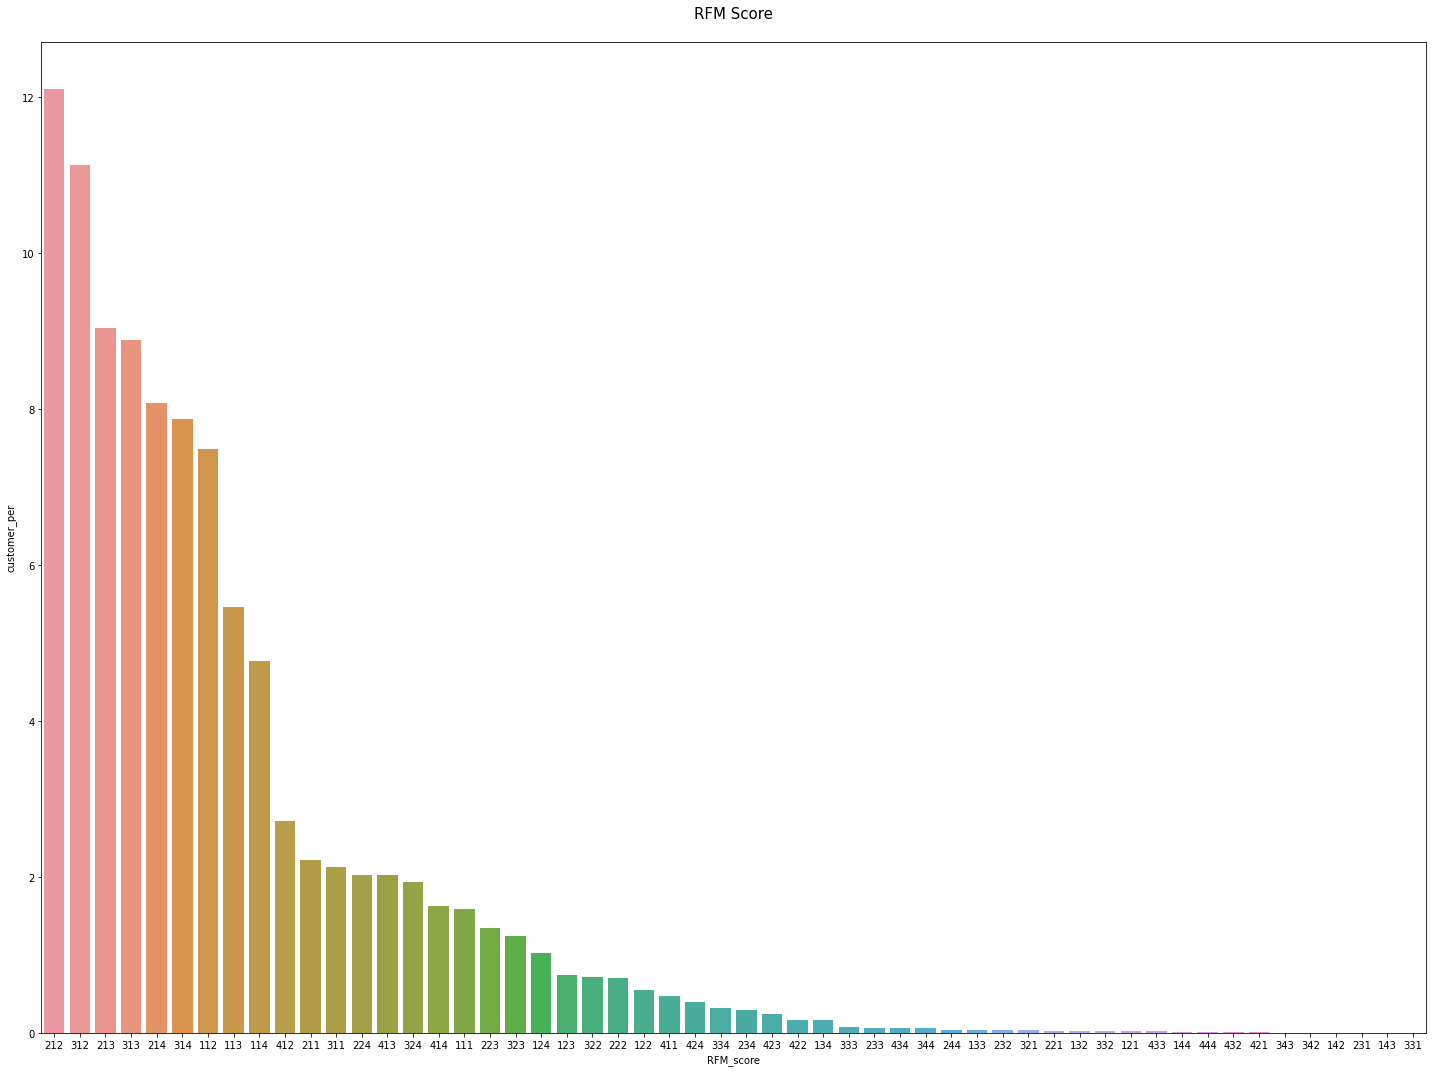

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

# распределение RFM_score
fig, ax = plt.subplots(figsize = (20, 15))
sns.barplot(data = rfm_count, x = 'RFM_score', y = 'customer_per')
ax.set_title('RFM Score\n', fontsize = 15)
plt.tight_layout()

На этом графике мы видим, что пользователи сегмента "111" совершали покупки очень давно и на меленькую сумму. Особой прибыли они нам не приносят. Наиболее часто и на большую сумму покупают пользователи категории "444".
Если говорить о пользователях категирой "144", "244", "134" и т.д. они покупали на хорошую сумму, но сейчас стали менее вактивны.   

Основная дола покупателей это "212" и "312", это значит, что покупки были сделаны от 1 до 6 месяцев назад, а суммарный объем покупок составляет от 20 до 70. Это показывает на небольшой средний чек и минимальный retention.

Теперь можно посмотреть на среднее значение в сегментах и как они распределяются.

In [73]:
rfm_mean = rfm.groupby('RFM_score', as_index = False) \
    .agg({'R' : 'mean', 'F' : 'mean', 'M' : 'mean'})
rfm_mean.head()

,RFM_score,R,F,M
0,111,466.601210,1.0,15.925750
1,112,463.399799,1.0,46.060514
2,113,464.013535,1.0,103.785536
3,114,466.271583,1.0,333.677795
4,121,458.000000,2.0,16.214118


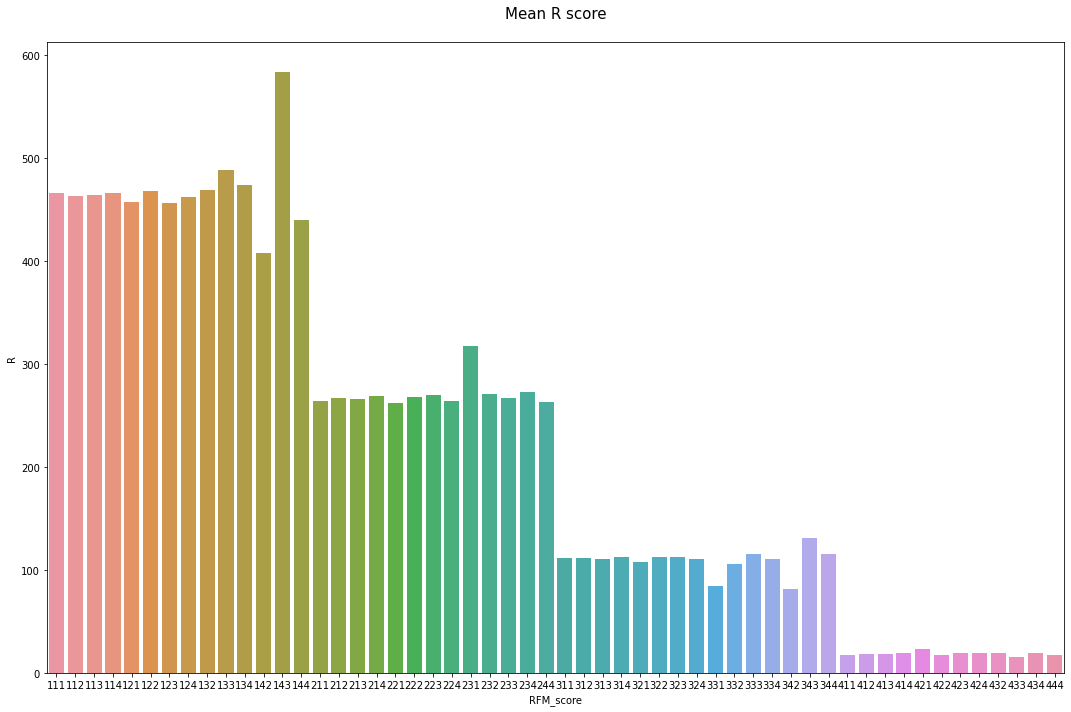

In [74]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.barplot(data = rfm_mean, x = 'RFM_score', y = 'R')
ax.set_title('Mean R score\n', fontsize = 15)
plt.tight_layout()

На этом графике видим почти равномерное уменьшение времени от даты последней покупки до текущей даты при увеличении первого числа сегмента.

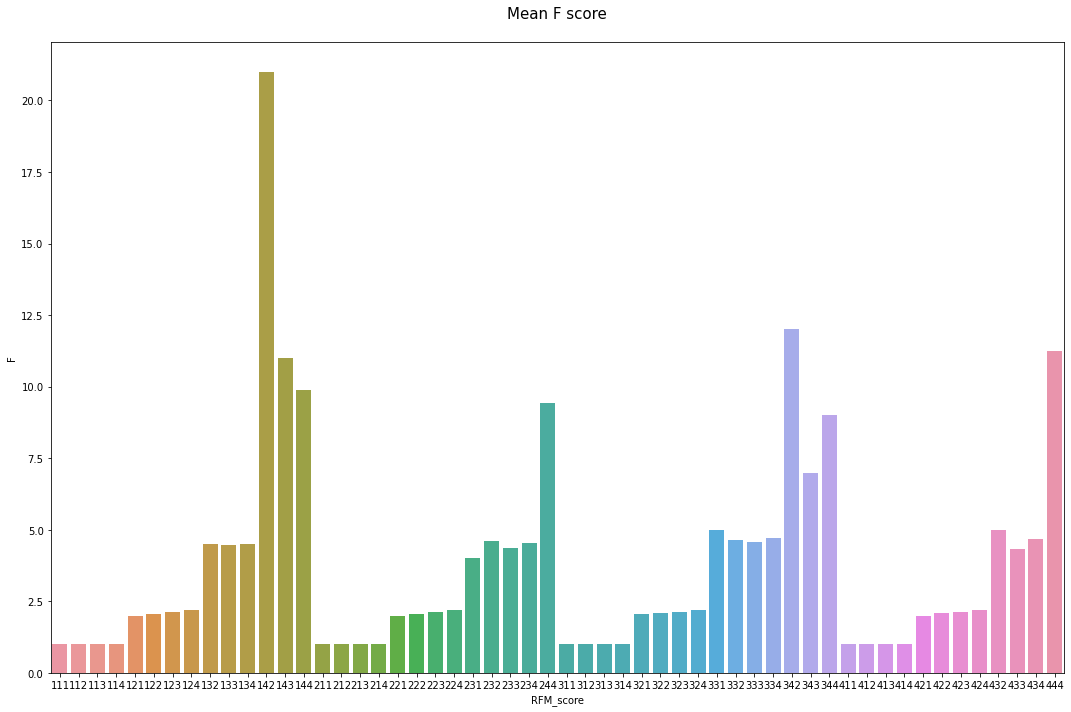

In [75]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.barplot(data = rfm_mean, x = 'RFM_score', y = 'F')
ax.set_title('Mean F score\n', fontsize = 15)
plt.tight_layout()

График имеет ступенькообразный вид поскольку у нас возрастает второе число в оценке. Самое большое число покупок у нас совершили давние пользователи.

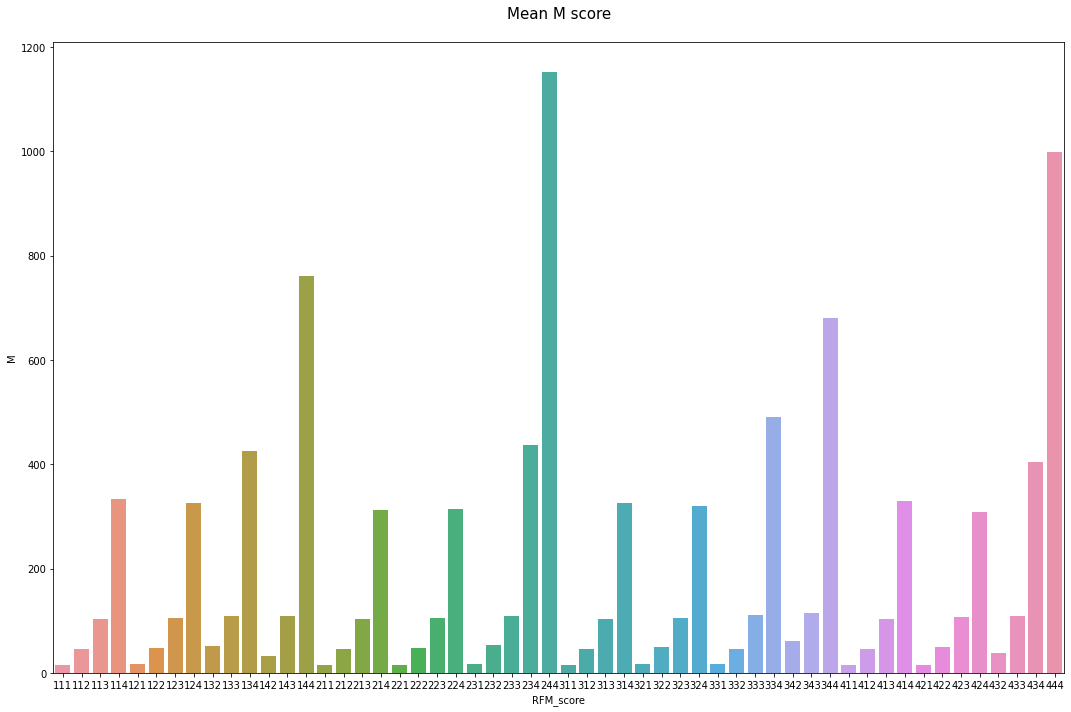

In [76]:
fig, ax = plt.subplots(figsize = (15, 10))
sns.barplot(data = rfm_mean, x = 'RFM_score', y = 'M')
ax.set_title('Mean M score\n', fontsize = 15)
plt.tight_layout()

Этот график тоже имеет ступенькообразный вид.